In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib notebook

from run_utils import run_env_experiment, plot_ratings_mses

sys.path.append('../') 
from reclab.environments.latent_factors import DatasetLatentFactor, LatentFactorBehavior
from reclab.environments.topics import Topics
from reclab.environments.engelhardt import Engelhardt


from reclab import data_utils

import seaborn as sns


/home/sarah/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
# TODO for all users, N percentile item rating!

In [11]:
def get_dense_ratings(env):
    users, items, ratings = env.reset()
    rating_matrix = np.zeros([len(users), len(items)])
    for u in users.keys():
        for i in items.keys():
            rating_matrix[u,i] = env._get_rating(u, i)
    return rating_matrix

def plot_average_rating_hists(rating_matrix, quantile=0.9, bins=np.linspace(0,5.5,12)):
    average_item_ratings = np.nanmean(rating_matrix, axis=0)
    average_user_ratings = np.nanmean(rating_matrix, axis=1)
    quantile_user_ratings = np.nanquantile(rating_matrix, quantile, axis=1)
    
    def plot_hist(data, title):
        plt.hist(data, bins=bins)
        plt.title(title)
        if bins is not None: 
            plt.xlim([-0.1,5.6])
            plt.xticks(np.linspace(0,5,6))
    
    plt.figure(figsize=[12,3])
    plt.subplot(1,4,1)
    plot_hist(average_item_ratings, "Average item Ratings")
    
    plt.subplot(1,4,2)
    plot_hist(average_user_ratings, "Average user Ratings")
    
    plt.subplot(1,4,3)
    plot_hist(quantile_user_ratings, "{}-Quantile user Ratings".format(quantile))

    plt.subplot(1,4,4)
    all_ratings = rating_matrix.flatten()
    all_ratings = all_ratings[np.logical_not(np.isnan(all_ratings))]
    plot_hist(all_ratings, "All Ratings")
    plt.tight_layout()

In [3]:
num_users = 943
num_items = 1682

env_params = {
    'num_users': num_users,
    'num_items': num_items,
    'rating_frequency': 0.5,
    'num_init_ratings': 0
}


# ML-100K Model

In [409]:
params = {'latent_dim': 8}


env_params_dataset = {key:env_params[key] for key in env_params.keys() if key not in ['num_users', 'num_items']}
for key in ['num_users', 'num_items']:
    env_params_dataset['max_'+key] = env_params[key]
env = DatasetLatentFactor('ml-100k', **params, **env_params_dataset)
users, items, ratings = env.reset();

Loading model from ../reclab/../data/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.


In [410]:
def get_dense_ratings(env):
    users, items, ratings = env.reset()
    rating_matrix = np.zeros([len(users), len(items)])
    for u in users.keys():
        for i in items.keys():
            rating_matrix[u,i] = env._get_rating(u, i)
    return rating_matrix

In [411]:
rating_matrix = env._get_dense_ratings()

<IPython.core.display.Javascript object>


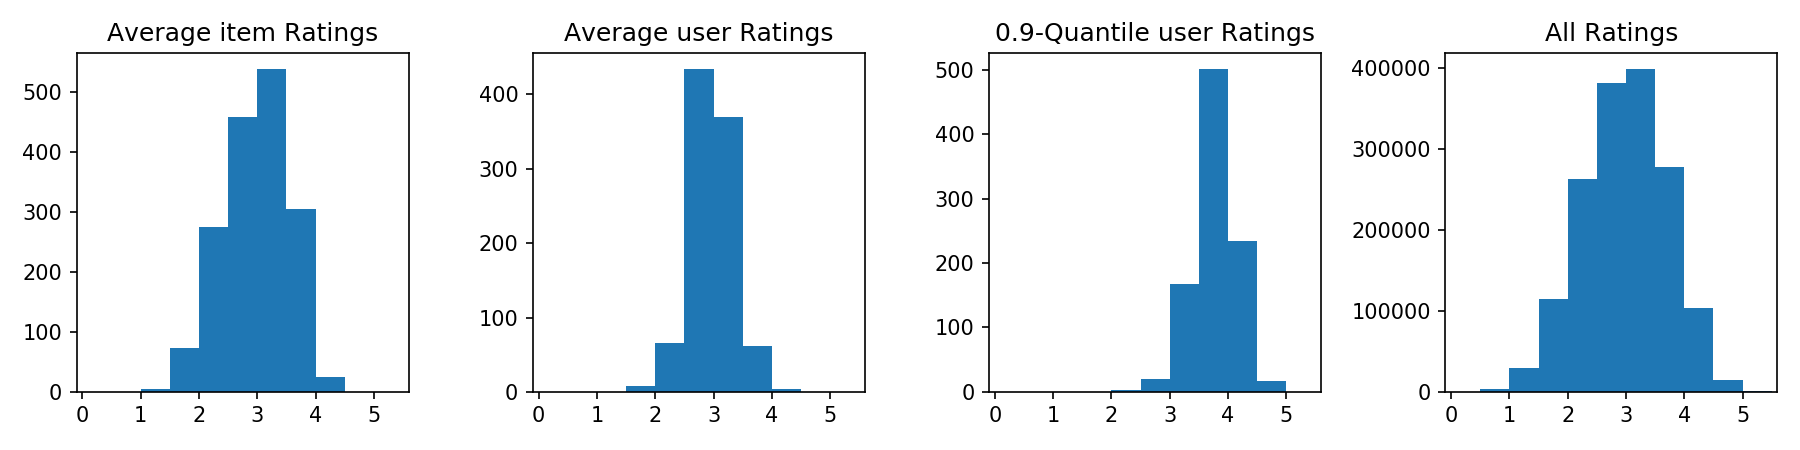

In [412]:
plot_average_rating_hists(rating_matrix)


In [413]:
dense_model_rating_matrix = rating_matrix

Text(0.5, 1, 'Euclidean Clusters')

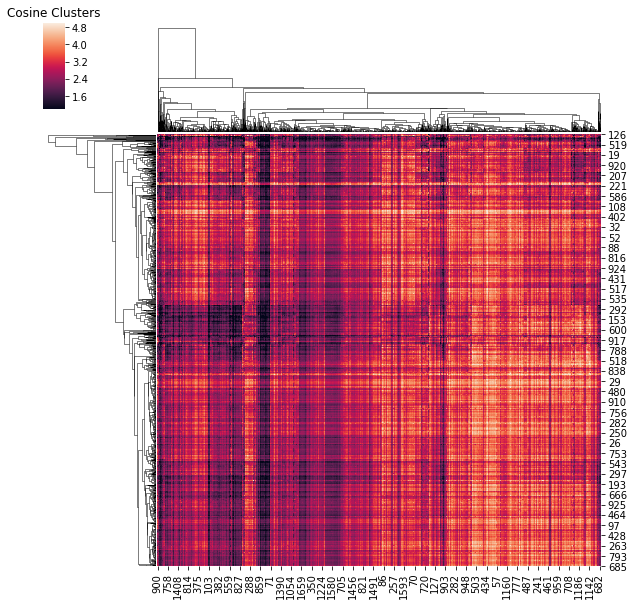

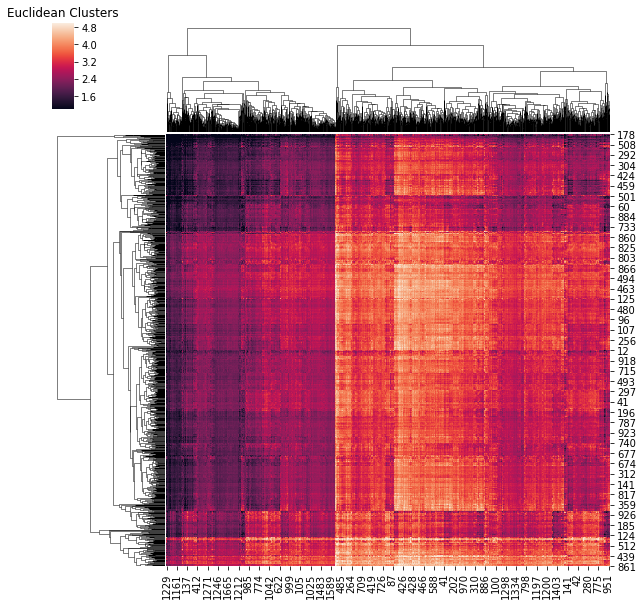

In [261]:

sns.clustermap(rating_matrix, metric='cosine')
plt.title('Cosine Clusters')

sns.clustermap(rating_matrix)
plt.title('Euclidean Clusters')

# Smaller ML-100K Model

In [380]:
params = {'latent_dim': 8}

env_params_dataset = {key:env_params[key] for key in env_params.keys() if key not in ['num_users', 'num_items']}
env_params_dataset['max_num_users'] = env_params['num_users'] // 2
env_params_dataset['max_num_items'] = env_params['num_items']  // 2

env = DatasetLatentFactor('ml-100k', **params, **env_params_dataset)


In [384]:
rating_matrix = env._get_dense_ratings()

<IPython.core.display.Javascript object>


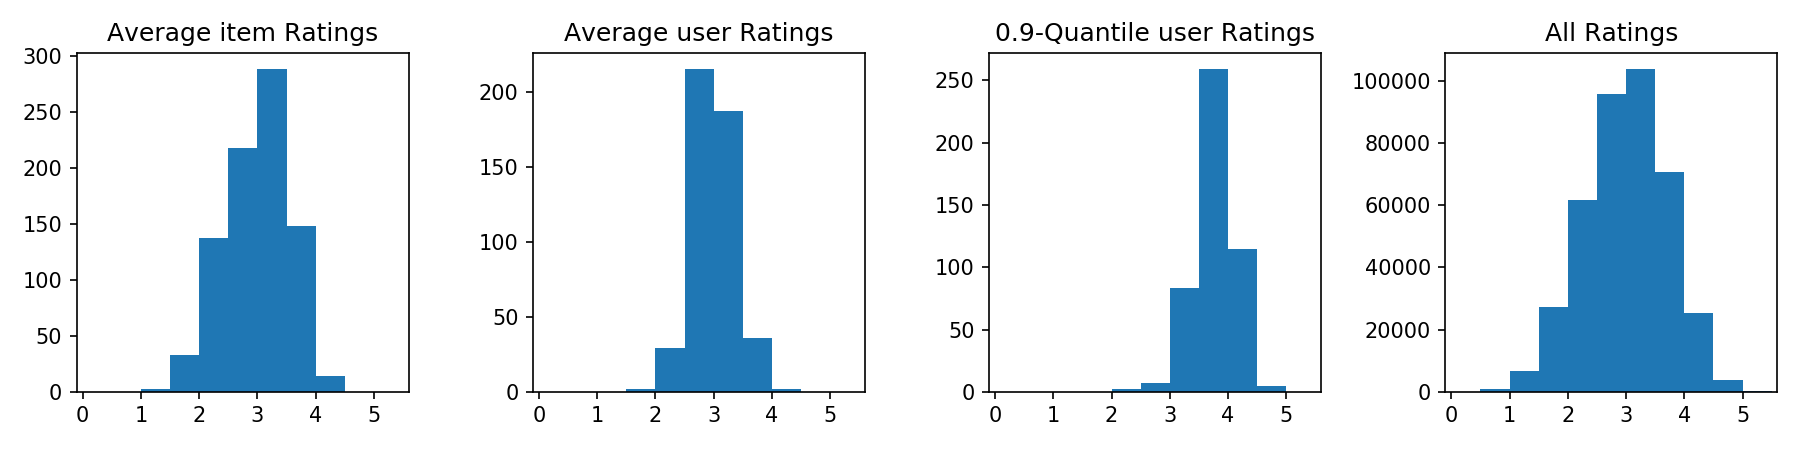

In [385]:
plot_average_rating_hists(rating_matrix)

Text(0.5, 1, 'Euclidean Clusters')

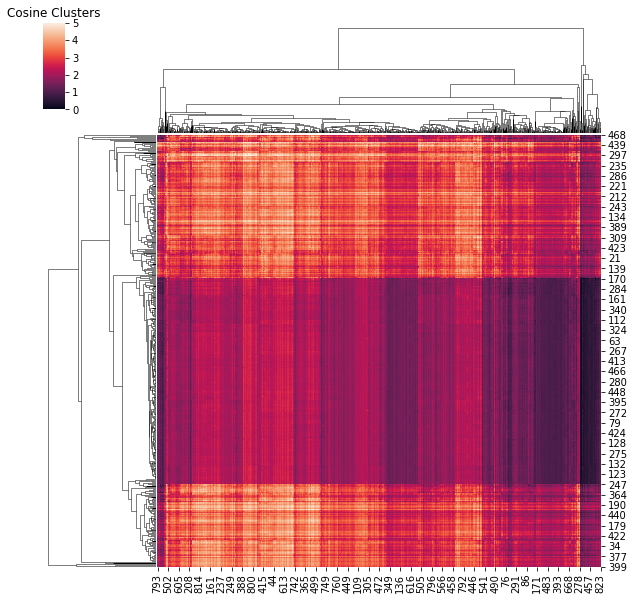

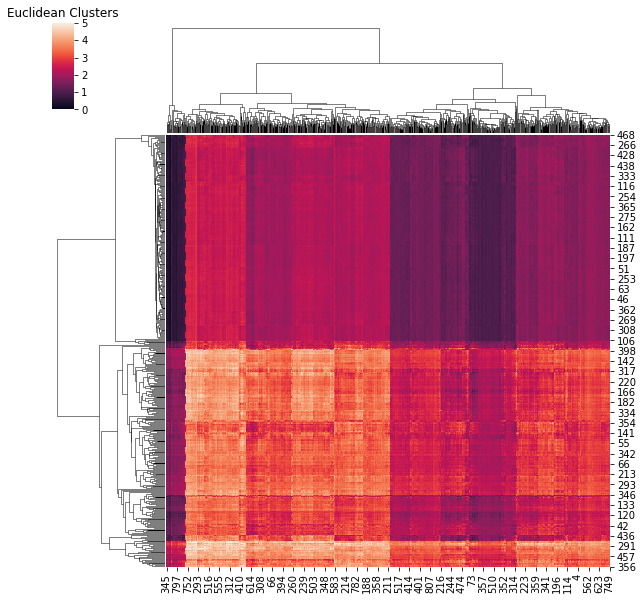

In [15]:

sns.clustermap(rating_matrix, metric='cosine')
plt.title('Cosine Clusters')

sns.clustermap(rating_matrix)
plt.title('Euclidean Clusters')

# ML-100K Data

In [386]:
users, items, ratings = data_utils.read_dataset('ml-100k')
print(len(users), len(items))

943 1682


In [387]:
rating_matrix = np.nan * np.ones([len(users), len(items)])
for key in ratings.keys():
    u, i = key
    rating_matrix[u-1, i-1] = ratings[key][0]

In [388]:
average_item_ratings = np.nanmean(rating_matrix, axis=0)
average_user_ratings = np.nanmean(rating_matrix, axis=1)

<IPython.core.display.Javascript object>


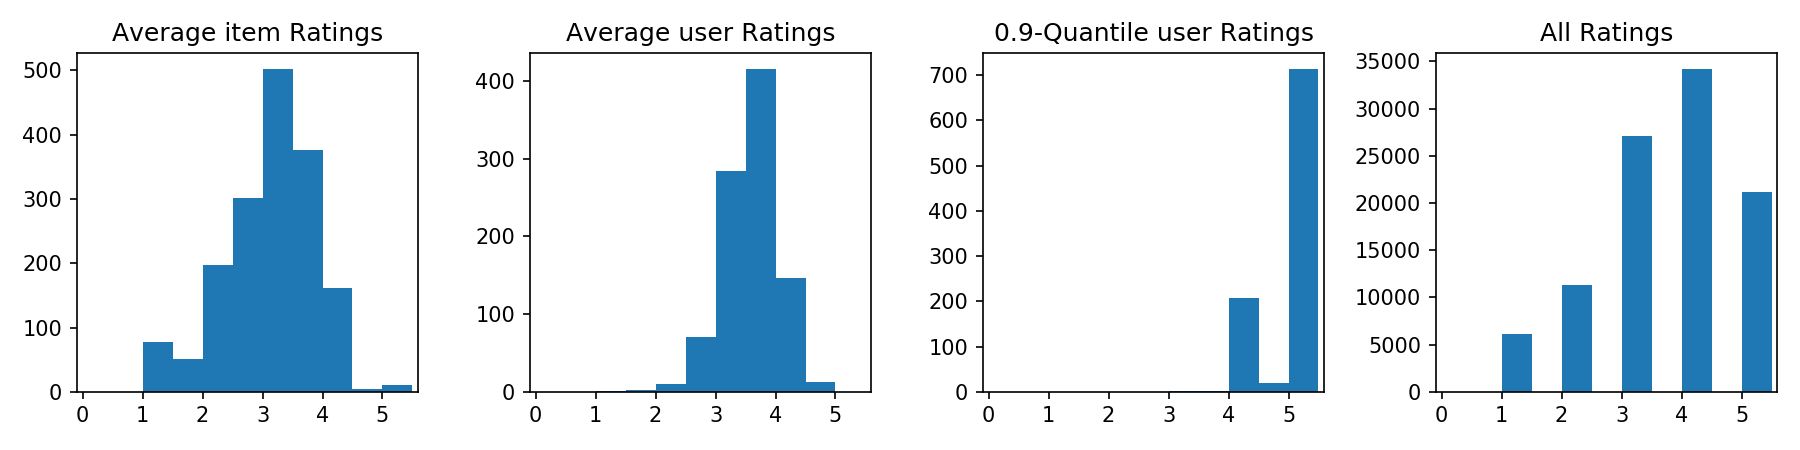

In [389]:
plot_average_rating_hists(rating_matrix)

# ML-100K Deconvolved

In [414]:
def deconv(Robs,alpha):
    # % Robs: a mxn matrix of observed ratings
    # % alpha: parameter controlling the deconvolving of feedback loops
    # % Rdeconv: a mxn matrix of deconvolved ratings
    # TODO: implement for scipy sparse matrix instead
    NR = np.sum(Robs>0, axis=1) # Vector of number of ratings of users
    Sum_Rat = np.sum(Robs, axis=1); # Vector of sum of ratings of every user
    Avg_Rat = Sum_Rat / NR;
    # Vector of average rating of each user
    # Rmean = (sparse(diag(Avg_Rat))*ones(size(Robs))); # Full matrix of average ratings
    # Rmean = Rmean.*(Robs>0); # Sparse matrix of average ratings for rated items
    Robs_c = Robs - Avg_Rat.reshape(-1,1); # User centered ratings matrix
    item_norms = (np.sum(Robs_c**2, axis=0)); # Item norms
    print(item_norms)
    Robs_cn = Robs_c * 1./np.sqrt(item_norms)
    # User centered & normalized ratings matrix
    U,singvalobs,VT = scipy.linalg.svd(Robs_cn, full_matrices=False); # Singular value decomposition
    assert np.abs(np.min(U@np.diag(singvalobs)@VT -Robs_cn)) < 1e-6
    singvaltrue = -1./(2*alpha*singvalobs) + np.sqrt((1./(4*alpha**2*singvalobs**2)) +1/alpha); # transformed values
    Rdeconv = U @ np.diag(singvaltrue) @ VT; #Deconvolved matrix
    # recenter?
    # Rdeconv = Rdeconv - (np.mean(Rdeconv, axis=1) ).reshape(-1,1)
    # Rdeconv = Rdeconv * 1./np.sqrt((np.sum(Rdeconv**2, axis=0)))
    # un-normalize
    Rnew = Rdeconv * np.sqrt(item_norms) + Avg_Rat.reshape(-1,1)
    # TODO scale Rnew
    return Robs_cn,Rdeconv, Rnew

In [415]:
users, items, ratings = data_utils.read_dataset('ml-100k')
print(len(users), len(items))

943 1682


In [417]:
rating_matrix = np.zeros([len(users), len(items)])
for key in ratings.keys():
    u, i = key
    rating_matrix[u-1, i-1] = ratings[key][0]

In [418]:
Robs_cn, Rdeconv, Rnew = deconv(dense_model_rating_matrix,0.1)

[460.95886669  62.23686792  79.92767848 ... 731.98992276  81.99150118
 172.68674684]


<IPython.core.display.Javascript object>


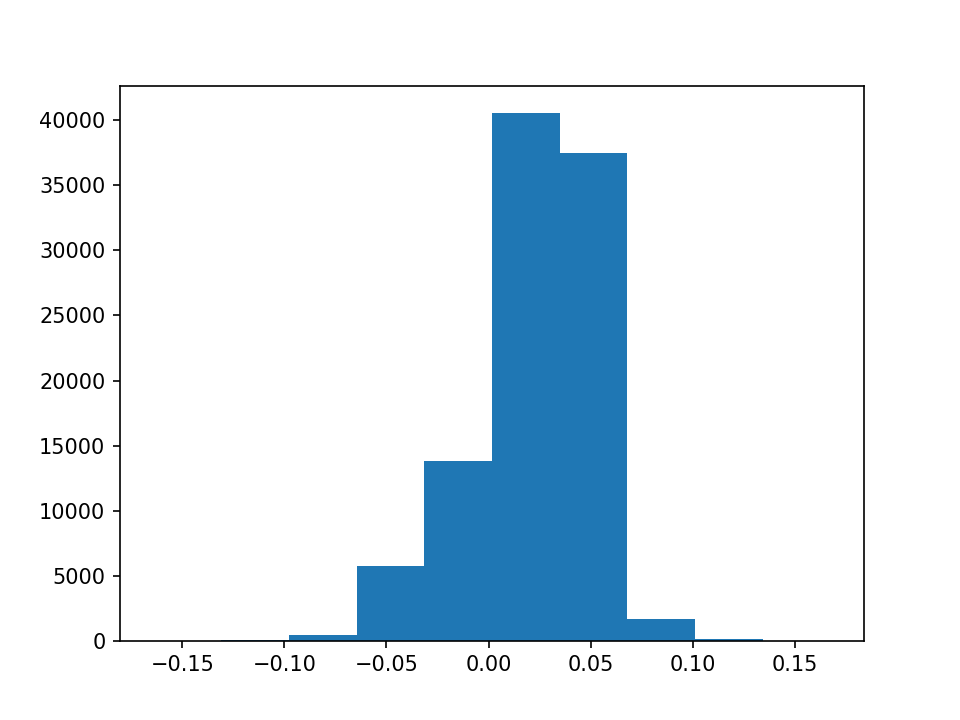

(array([1.1000e+01, 3.9000e+01, 4.5000e+02, 5.7430e+03, 1.3846e+04,
        4.0575e+04, 3.7503e+04, 1.6920e+03, 1.2300e+02, 1.8000e+01]),
 array([-0.16395326, -0.13082422, -0.09769518, -0.06456614, -0.0314371 ,
         0.00169194,  0.03482098,  0.06795002,  0.10107906,  0.13420809,
         0.16733713]),
 <a list of 10 Patch objects>)

In [419]:

plt.figure()
plt.hist(Robs_cn[rating_matrix > 0].flatten())

<IPython.core.display.Javascript object>


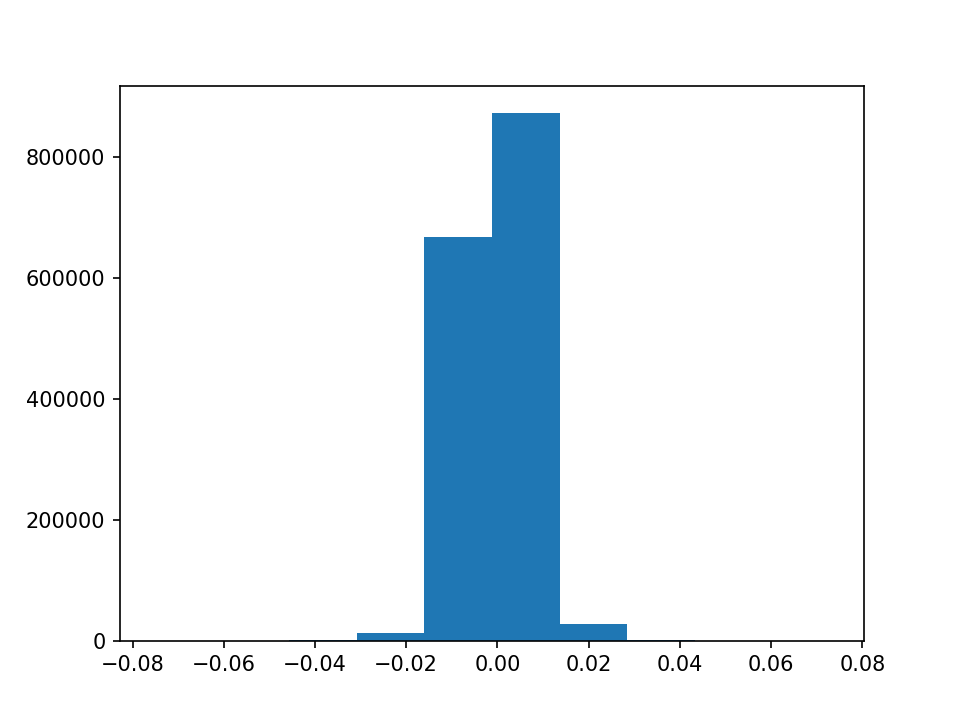

(array([1.90000e+01, 1.11000e+02, 9.34000e+02, 1.36960e+04, 6.68588e+05,
        8.73714e+05, 2.71230e+04, 1.74600e+03, 1.68000e+02, 2.70000e+01]),
 array([-0.07533045, -0.06050358, -0.04567672, -0.03084985, -0.01602299,
        -0.00119612,  0.01363075,  0.02845761,  0.04328448,  0.05811134,
         0.07293821]),
 <a list of 10 Patch objects>)

In [420]:

plt.figure()
plt.hist(Rdeconv.flatten())

<IPython.core.display.Javascript object>


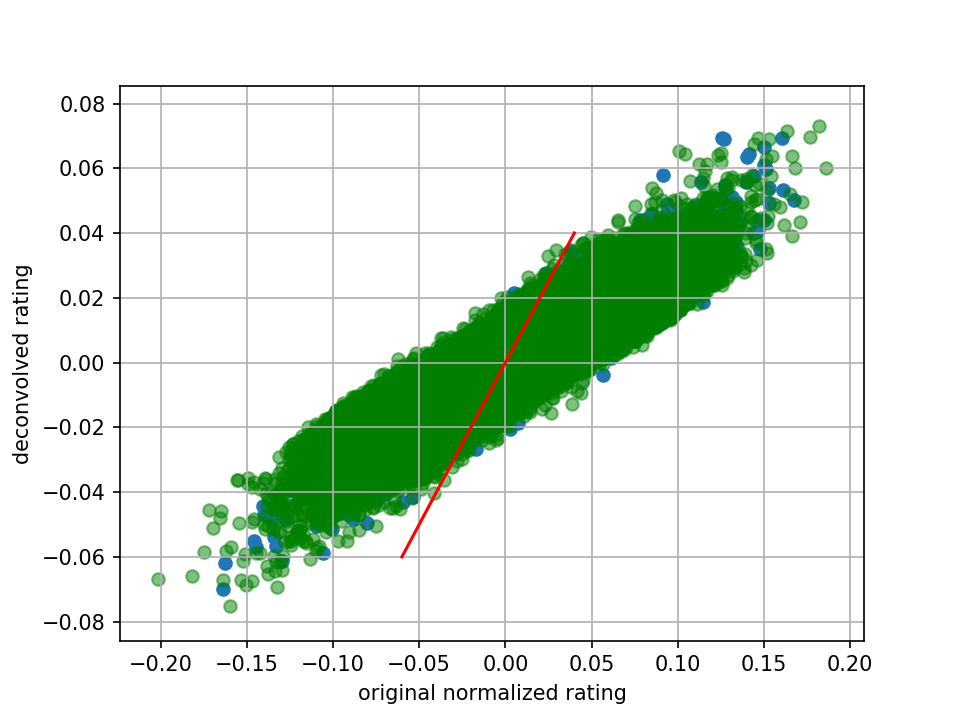

In [423]:
plt.figure()
plt.scatter(Robs_cn[rating_matrix > 0].flatten(), Rdeconv[rating_matrix > 0].flatten(), )
plt.scatter(Robs_cn[rating_matrix == 0].flatten(), Rdeconv[rating_matrix == 0].flatten(), c='green', alpha=0.5)
plt.ylabel('deconvolved rating')
plt.xlabel('original normalized rating')
plt.plot(np.linspace(-0.06, 0.04, 10), np.linspace(-0.06, 0.04, 10), color='red')
plt.grid()

<IPython.core.display.Javascript object>


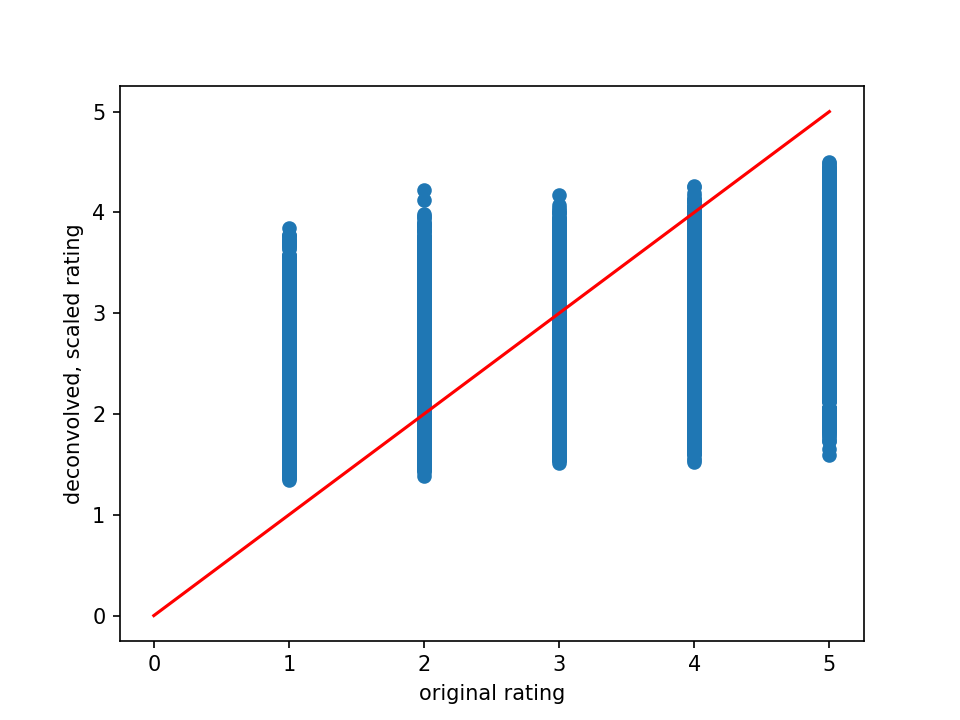

In [424]:
plt.figure()
plt.scatter(rating_matrix[rating_matrix > 0].flatten(), Rnew[rating_matrix > 0].flatten(), )
plt.ylabel('deconvolved, scaled rating')
plt.xlabel('original rating')
plt.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), color='red')


<IPython.core.display.Javascript object>


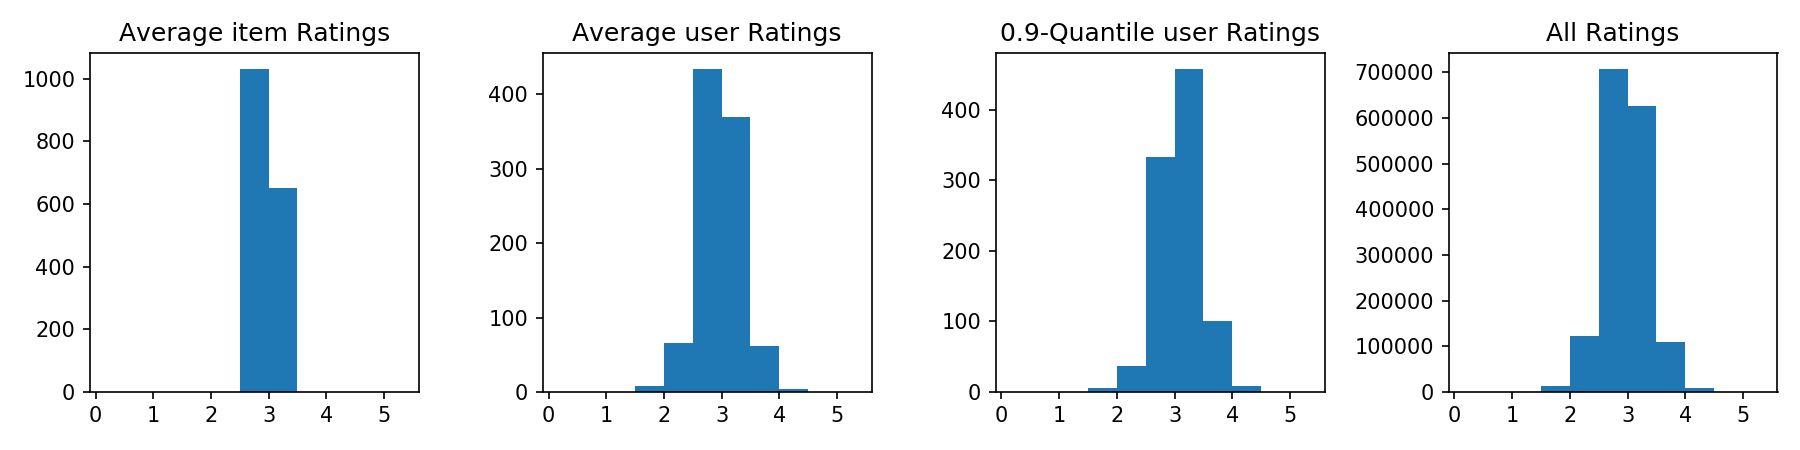

In [425]:
plot_average_rating_hists(Rnew)

<IPython.core.display.Javascript object>


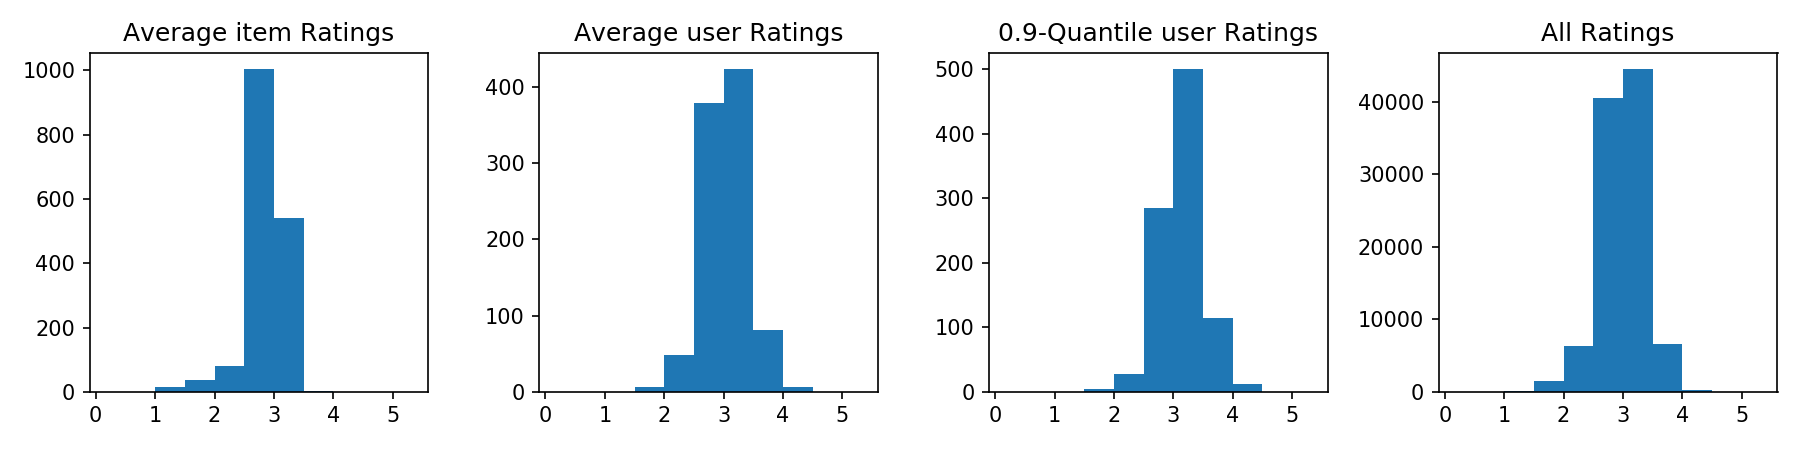

<IPython.core.display.Javascript object>


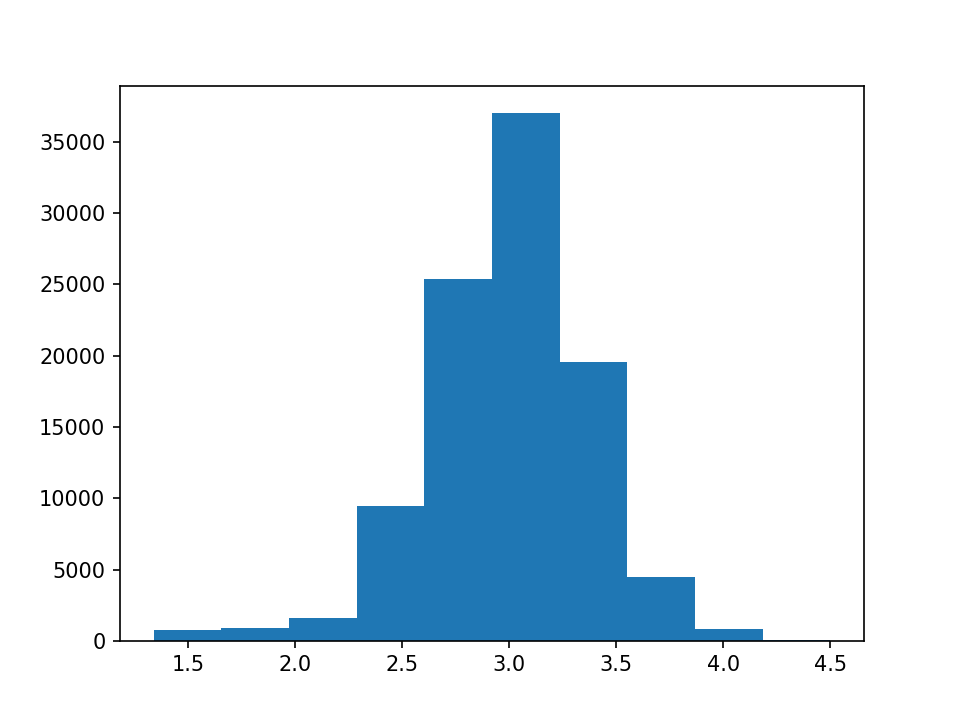

(array([  725.,   881.,  1594.,  9477., 25402., 37039., 19530.,  4466.,
          818.,    68.]),
 array([1.34158471, 1.65735189, 1.97311908, 2.28888627, 2.60465345,
        2.92042064, 3.23618783, 3.55195501, 3.8677222 , 4.18348939,
        4.49925657]),
 <a list of 10 Patch objects>)

In [426]:
Rnew_mask = Rnew.copy()
Rnew_mask[rating_matrix == 0] = np.nan
plot_average_rating_hists(Rnew_mask)


all_ratings = Rnew_mask.flatten()
all_ratings = all_ratings[np.logical_not(np.isnan(all_ratings))]
plt.figure()
plt.hist(all_ratings)

# Pinterest Deconvolve

In [315]:
def deconv_sparse_implicit(Robs,alpha):
    # % Robs: a mxn matrix of observed ratings
    # % alpha: parameter controlling the deconvolving of feedback loops
    # % Rdeconv: a mxn matrix of deconvolved ratings
    # TODO: implement for scipy sparse matrix instead
    # NR = np.sum(Robs>0, axis=1) # Vector of number of ratings of users
    Sum_Rat = np.sum(Robs, axis=1); # Vector of sum of ratings of every user
    Avg_Rat = Sum_Rat / Robs.shape[0];
    # Vector of average rating of each user
    # Rmean = (sparse(diag(Avg_Rat))*ones(size(Robs))); # Full matrix of average ratings
    # Rmean = Rmean.*(Robs>0); # Sparse matrix of average ratings for rated items
    Robs_c = Robs - Avg_Rat.reshape(-1,1); # User centered ratings matrix
    item_norms = (np.sum(Robs_c, axis=0)); # Item norms
    print(item_norms)
    Robs_cn = Robs_c * 1./np.sqrt(item_norms)
    # User centered & normalized ratings matrix
    singvalobs = np.zeros(min(Robs.shape))
    k=1
    U,sv,VT = scipy.sparse.linalg.svds(Robs_cn, k=k); # Singular value decomposition
    singvalobs[:k] = sv
#     assert np.abs(np.min(U@np.diag(singvalobs)@VT -Robs_cn)) < 1e-6
    singvaltrue = -1./(2*alpha*singvalobs) + np.sqrt((1./(4*alpha**2*singvalobs**2)) +1/alpha); # transformed values
    Rdeconv = U @ np.diag(singvaltrue) @ VT; #Deconvolved matrix
    # recenter?
    # Rdeconv = Rdeconv - (np.mean(Rdeconv, axis=1) ).reshape(-1,1)
    # Rdeconv = Rdeconv * 1./np.sqrt((np.sum(Rdeconv**2, axis=0)))
    # un-normalize
    Rnew = Rdeconv * np.sqrt(item_norms).T + Avg_Rat.reshape(-1,1)
    # TODO scale Rnew
    return Robs_cn,Rdeconv, Rnew

In [289]:
users, items, ratings = data_utils.read_dataset('pinterest')
print(len(users), len(items))

55187 9916


In [304]:
# rating_matrix = np.zeros([len(users), len(items)])
rating_matrix = scipy.sparse.dok_matrix((len(users), len(items)))
for key in ratings.keys():
    u, i = key
    rating_matrix[u-1, i-1] = ratings[key][0]

In [317]:
rating_matrix

<55187x9916 sparse matrix of type '<class 'numpy.float64'>'
	with 1410963 stored elements in Dictionary Of Keys format>

In [316]:
Robs_cn, Rdeconv, Rnew = deconv_sparse(rating_matrix,0.1)

MemoryError: Unable to allocate array with shape (545823329, 2) and data type int64

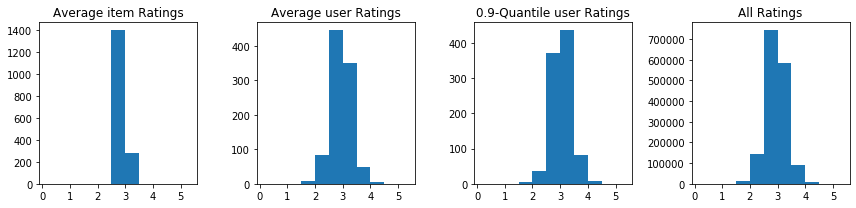

In [292]:
plot_average_rating_hists(Rnew, bins=np.linspace(0,1.5,12))

# Cite-U-Like Deconvolve

# Random Latent Factor Model


In [429]:
params = {'latent_dim': 8}

env = LatentFactorBehavior(**params, **env_params)
env.reset();

In [430]:
rating_matrix = env._get_dense_ratings()

<IPython.core.display.Javascript object>


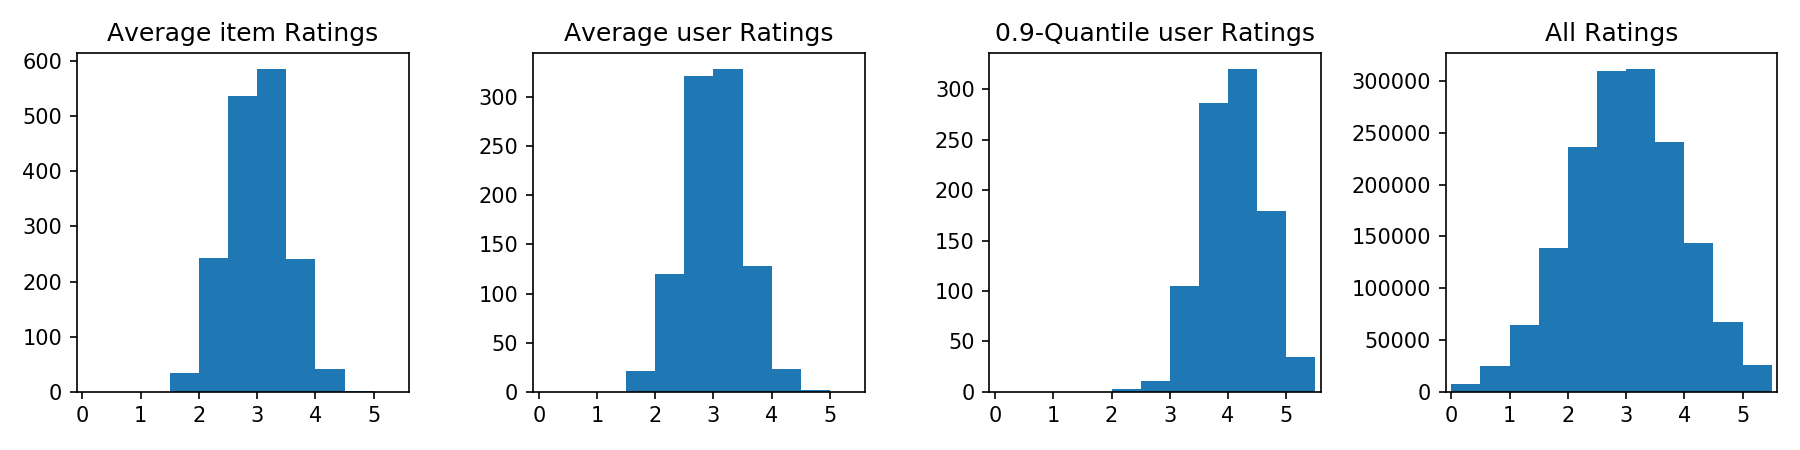

In [431]:
plot_average_rating_hists(rating_matrix)

Text(0.5, 1, 'Euclidean Clusters')

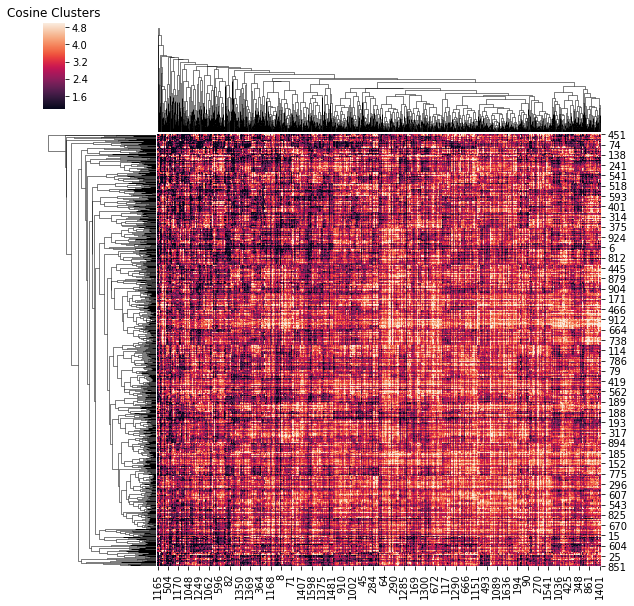

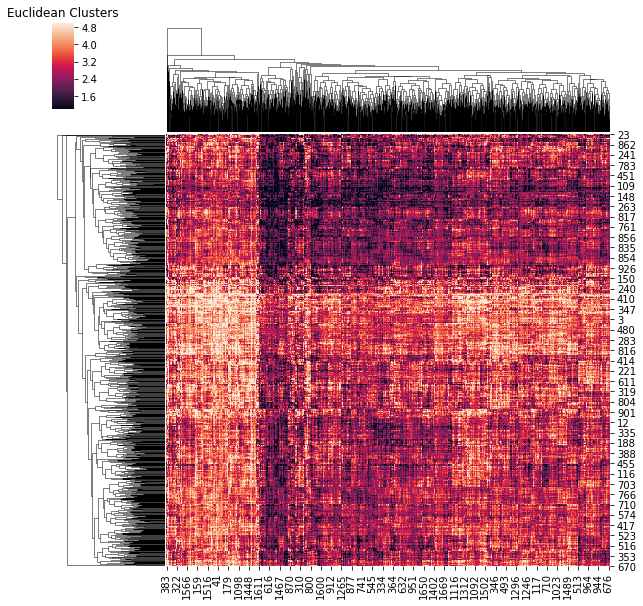

In [284]:

sns.clustermap(rating_matrix, metric='cosine')
plt.title('Cosine Clusters')

sns.clustermap(rating_matrix)
plt.title('Euclidean Clusters')

# Random Topics Model

In [434]:
params = {'num_topics': 20}

env = Topics(**params, **env_params)
env.reset();

In [435]:
rating_matrix = env._get_dense_ratings()

<IPython.core.display.Javascript object>


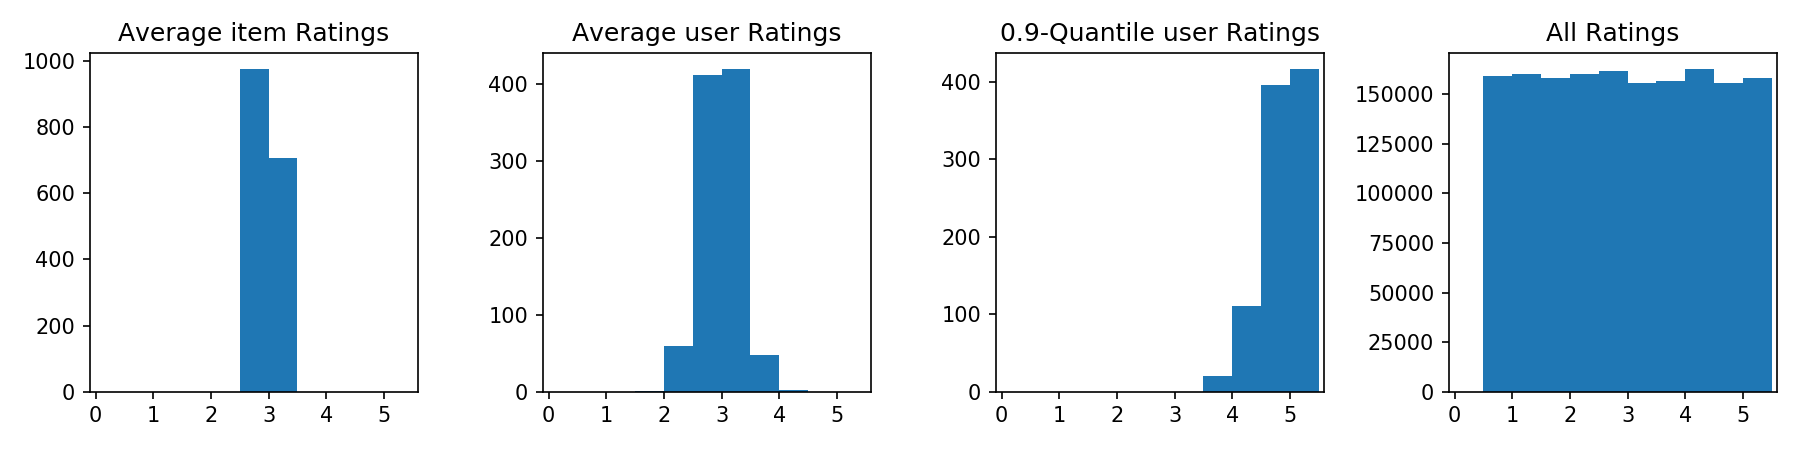

In [436]:
plot_average_rating_hists(rating_matrix)

In [28]:
np.max(rating_matrix)

5.0

<IPython.core.display.Javascript object>


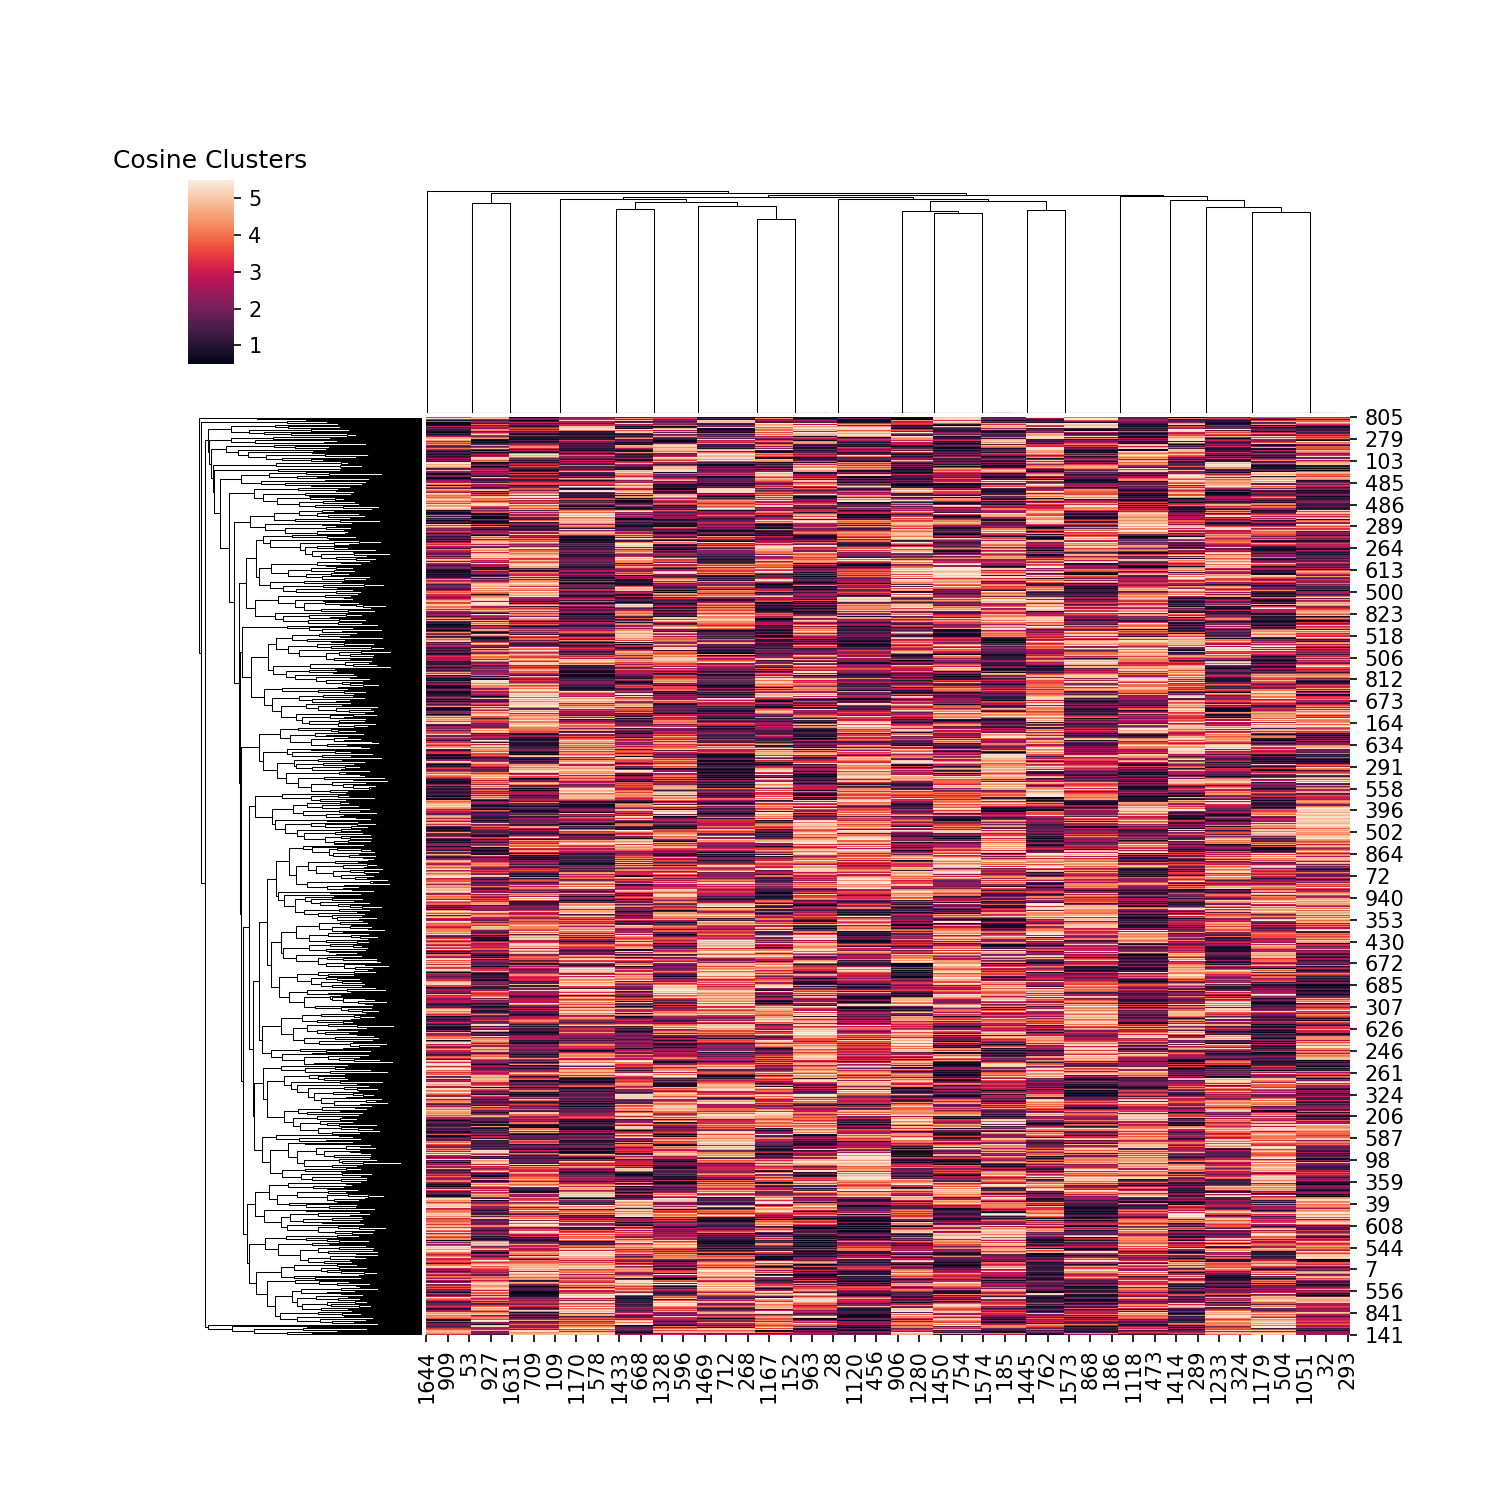

<IPython.core.display.Javascript object>


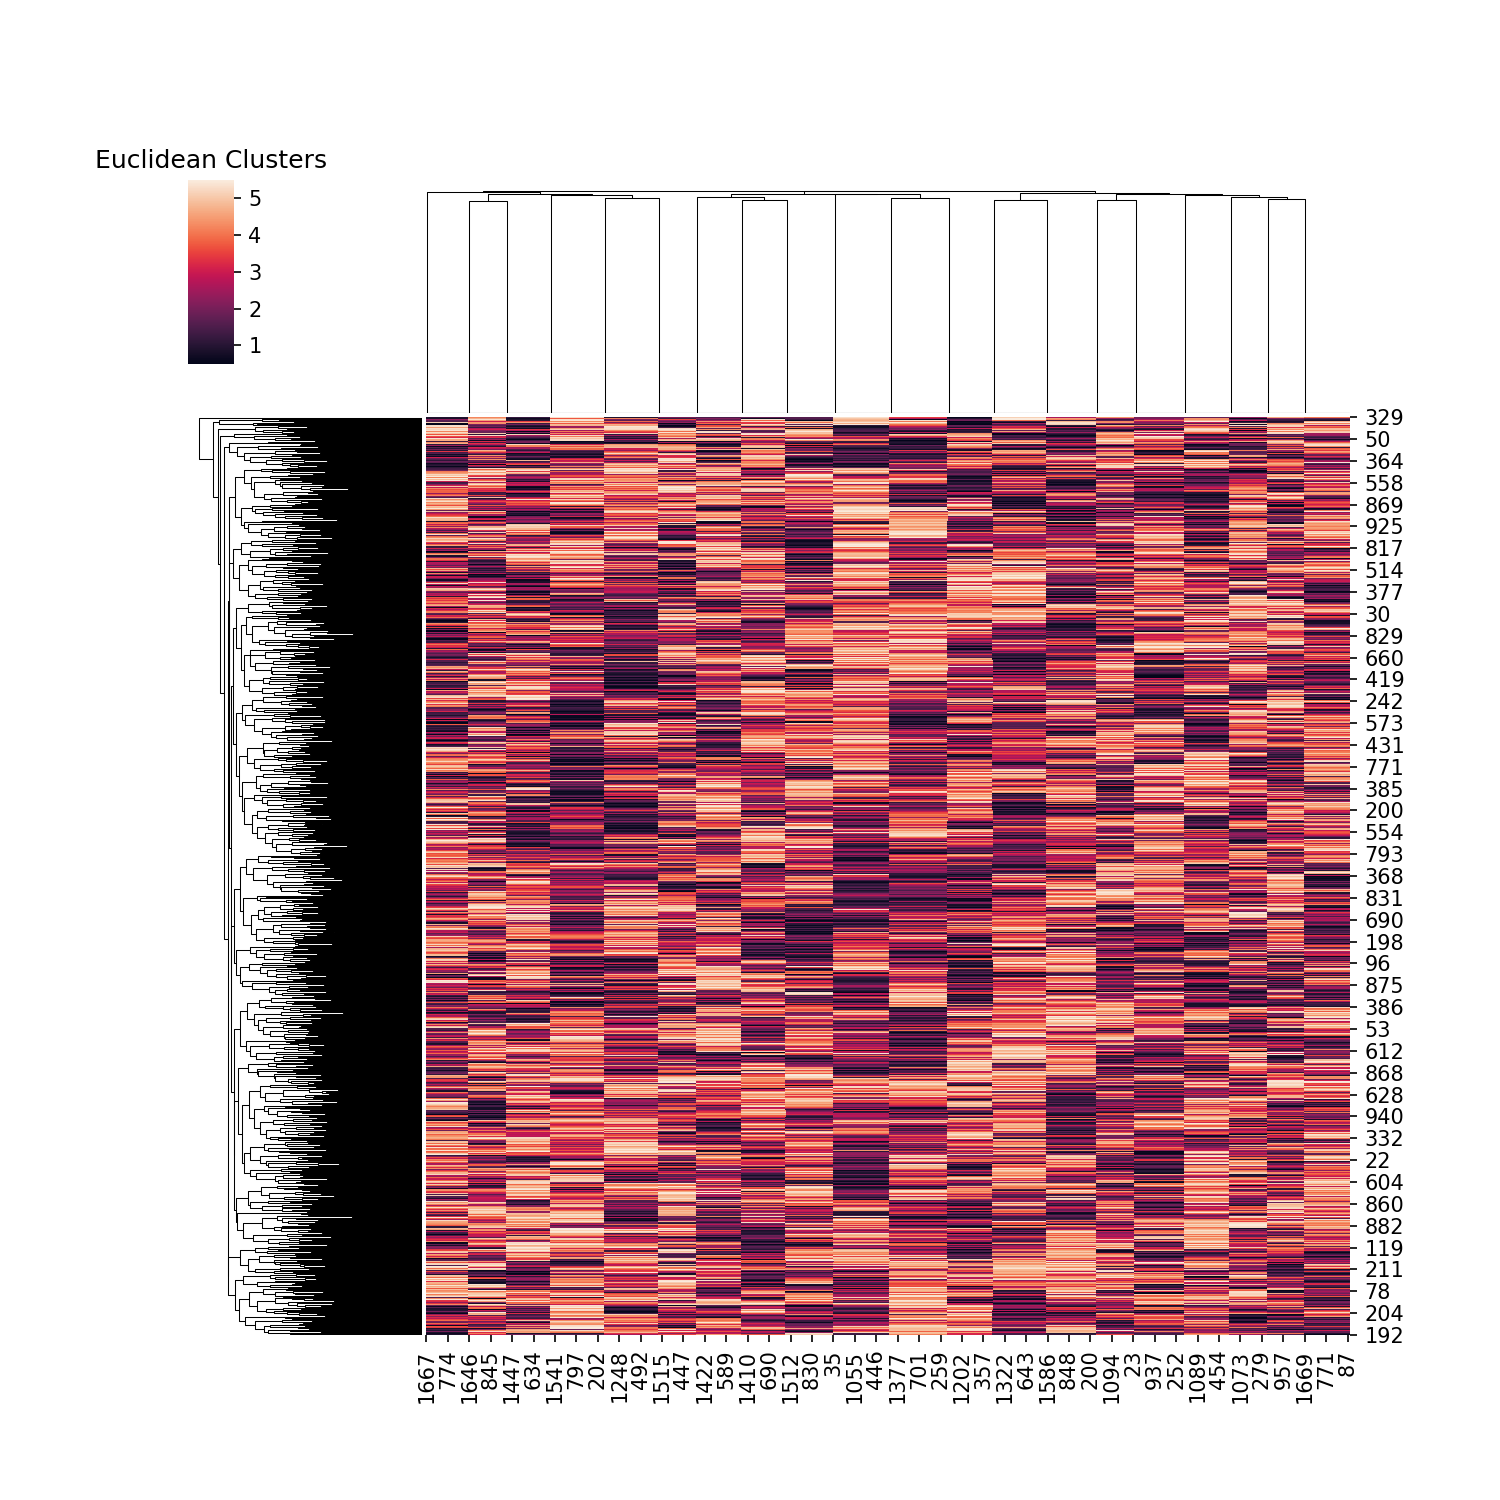

Text(0.5, 1, 'Euclidean Clusters')

In [437]:

sns.clustermap(rating_matrix, metric='cosine')
plt.title('Cosine Clusters')

sns.clustermap(rating_matrix)
plt.title('Euclidean Clusters')

# Engelhardt Model

In [13]:
params = {'num_topics': 20}

env = Engelhardt(**params, **env_params)
env.reset();


In [14]:
rating_matrix = env._get_dense_ratings()

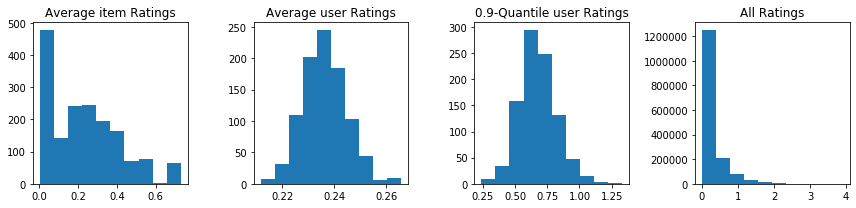

In [15]:
plot_average_rating_hists(rating_matrix, bins=None)